<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Variabelunders%C3%B8kelse-Pradeep/Bioco_Databehandling_av_ekstremverdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lasting av nødvendige pakker og bibliotek

In [1]:
! pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=28559ca1797e6ca67d582e8669cbdd3fd36665dd2beef264b9fb4c48bd971fab
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


Importering av nødvendige pakker og bibliotek

In [2]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF

from sklearn.cluster import DBSCAN

Importering av data

In [112]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
behandlet_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv',
                             header=0,
                             sep=',',
                             index_col=0)

# Formatterer index til riktig format og datatype
behandlet_data.index = pd.to_datetime(behandlet_data.index,
                                      format='%Y-%m-%d %H:%M:%S')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
behandlet_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjusted    460 non-null    float64
d

# Inspeksjon av mulige ekstremverdier

Henter prediktorer verdiene som skal undersøkes

In [114]:
prediktor_data = behandlet_data.iloc[:, 6:-4]
X = prediktor_data.values

In [115]:
prediktor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  29136 non-null  float64
 1   NIRfat         29136 non-null  float64
 2   NIRash         29136 non-null  float64
 3   NIRwater       29136 non-null  float64
 4   TT08           29136 non-null  float64
 5   TT20           29136 non-null  float64
 6   TT12           29136 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB


## Violin plot

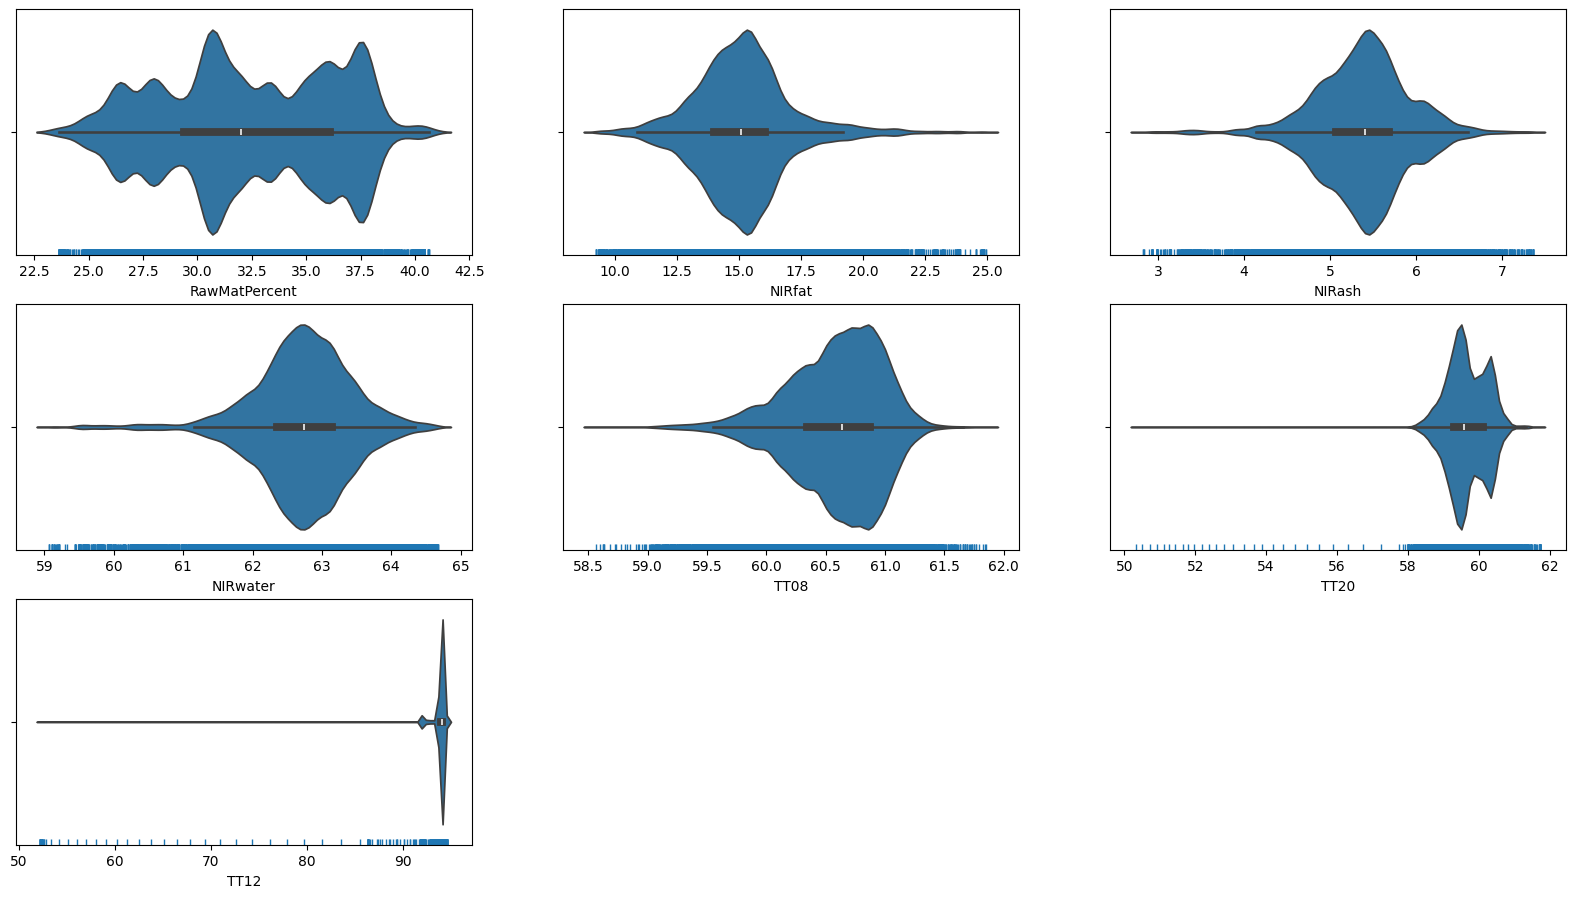

In [116]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data)
  sns.rugplot(x=prediktor_data[indeks])
  i += 1

## PCA analyse

## Ekstremverdi inspeksjon med HBOS

<ipython-input-117-6e57db1b5ed9>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-117-6e57db1b5ed9>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


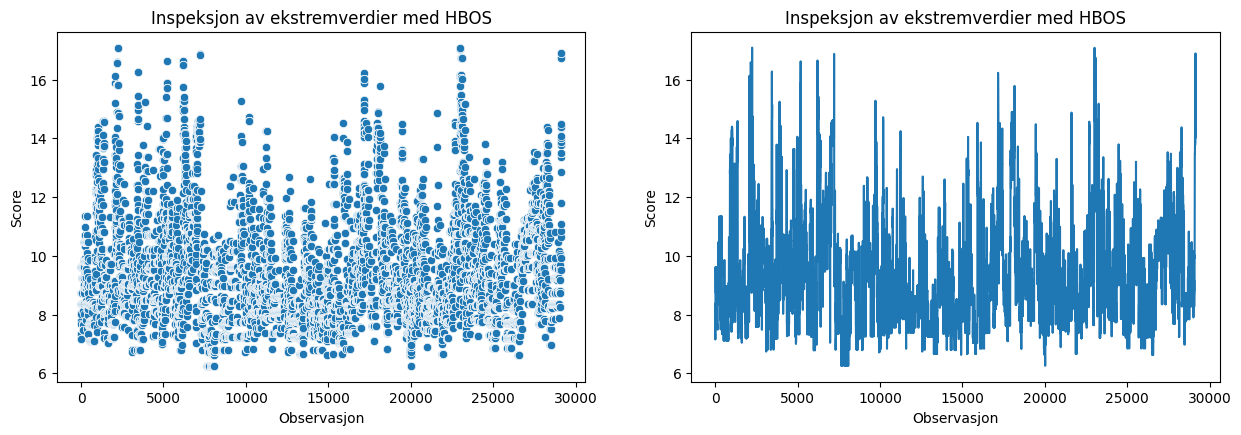

In [117]:
# Ekstremverdi inspeksjon med HBOS på data
hbos = HBOS()
hbos.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_hbos = hbos.labels_
y_scores_hbos = hbos.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_hbos)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")

plt.subplot(2,2,2)
plt.plot(list(y_scores_hbos))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")
plt.show()

In [147]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_hbos = 11

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_hbos_indeks = np.where(y_scores_hbos > terskel_hbos)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_hbos_terskel = prediktor_data.iloc[mulige_ekstrem_hbos_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_hbos = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_hbos_indeks])

# Data etter inspeksjon med HBOS
print("Data etter HBOS:")
print(behandlet_data_hbos.info())

Data etter HBOS:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24285 entries, 2022-10-31 17:37:00 to 2023-06-14 00:15:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  24285 non-null  float64
 1   NIRfat         24285 non-null  float64
 2   NIRash         24285 non-null  float64
 3   NIRwater       24285 non-null  float64
 4   TT08           24285 non-null  float64
 5   TT20           24285 non-null  float64
 6   TT12           24285 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB
None


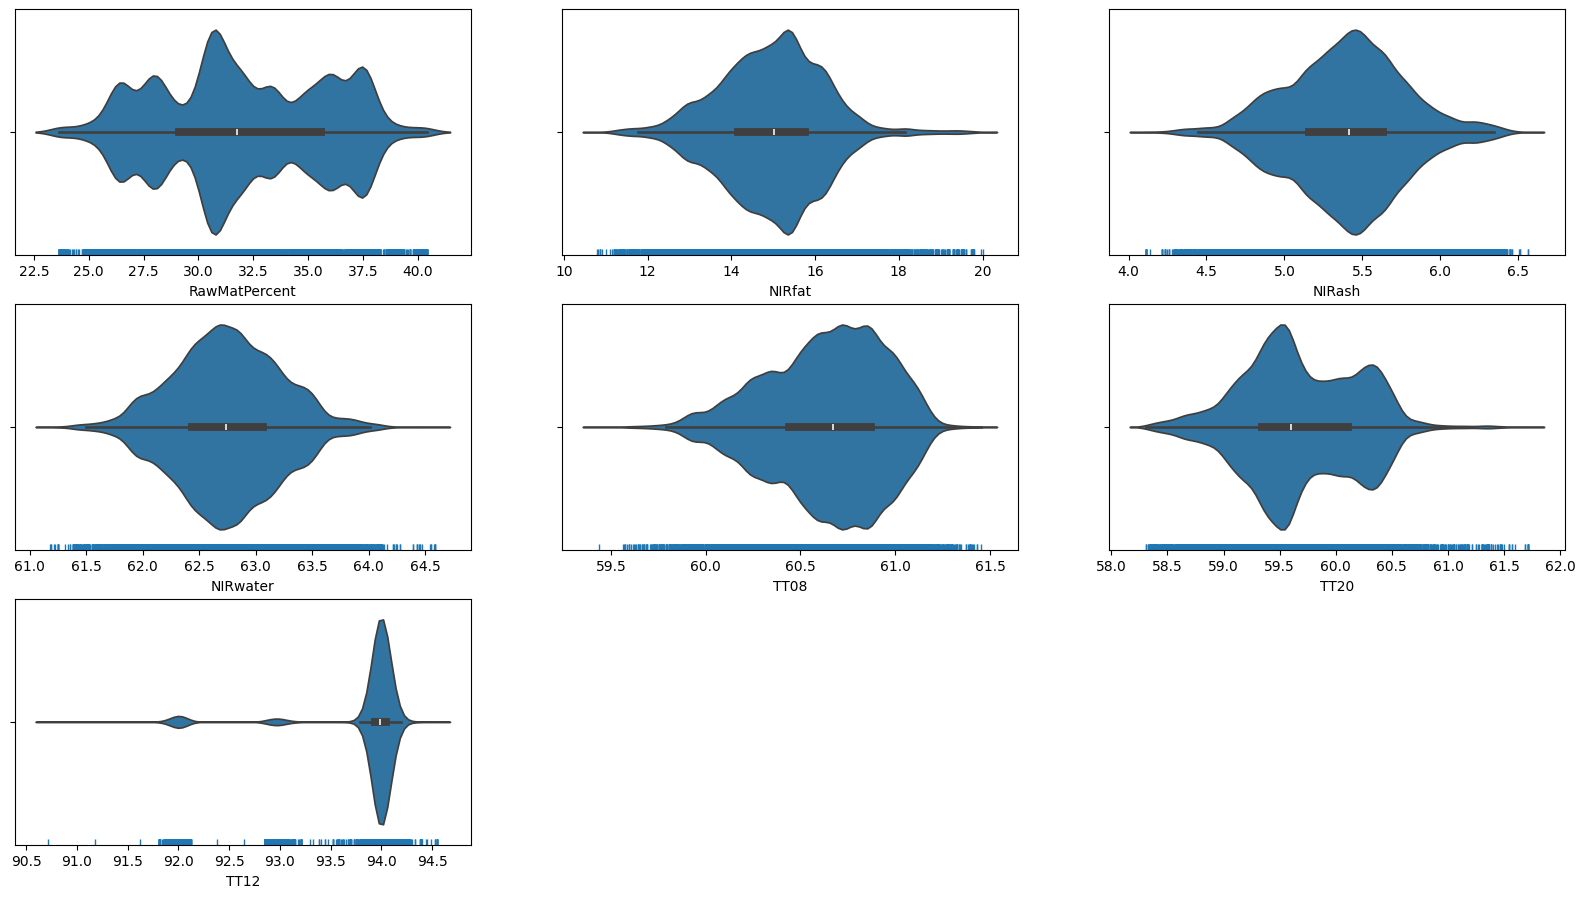

In [49]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_hbos.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_hbos):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_hbos)
  sns.rugplot(x=behandlet_data_hbos[indeks])
  i += 1

## Ekstremsverdi inspeksjon med CBLOF

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-119-9df2ac957c6f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-119-9df2ac957c6f>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


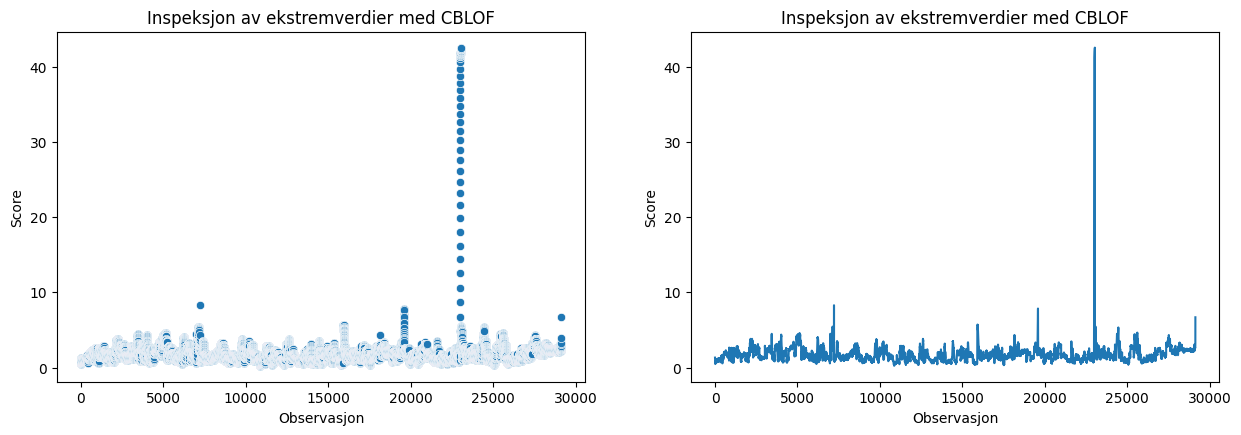

In [119]:
# Ektremverdiinspeksjon med CBLOF på data
cblof = CBLOF()
cblof.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_cblof = cblof.labels_
y_scores_cblof = cblof.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_cblof)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")

plt.subplot(2,2,2)
plt.plot(list(y_scores_cblof))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")
plt.show()

In [138]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_cblof = 3

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_cblof_indeks = np.where(y_scores_cblof > terskel_cblof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_cblof_terskel = prediktor_data.iloc[mulige_ekstrem_cblof_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_cblof = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_cblof_indeks])

# Data etter inspeksjon med CBLOF
print("Data etter CBLOF:")
print(behandlet_data_cblof.info())

Data etter CBLOF:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27172 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  27172 non-null  float64
 1   NIRfat         27172 non-null  float64
 2   NIRash         27172 non-null  float64
 3   NIRwater       27172 non-null  float64
 4   TT08           27172 non-null  float64
 5   TT20           27172 non-null  float64
 6   TT12           27172 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB
None


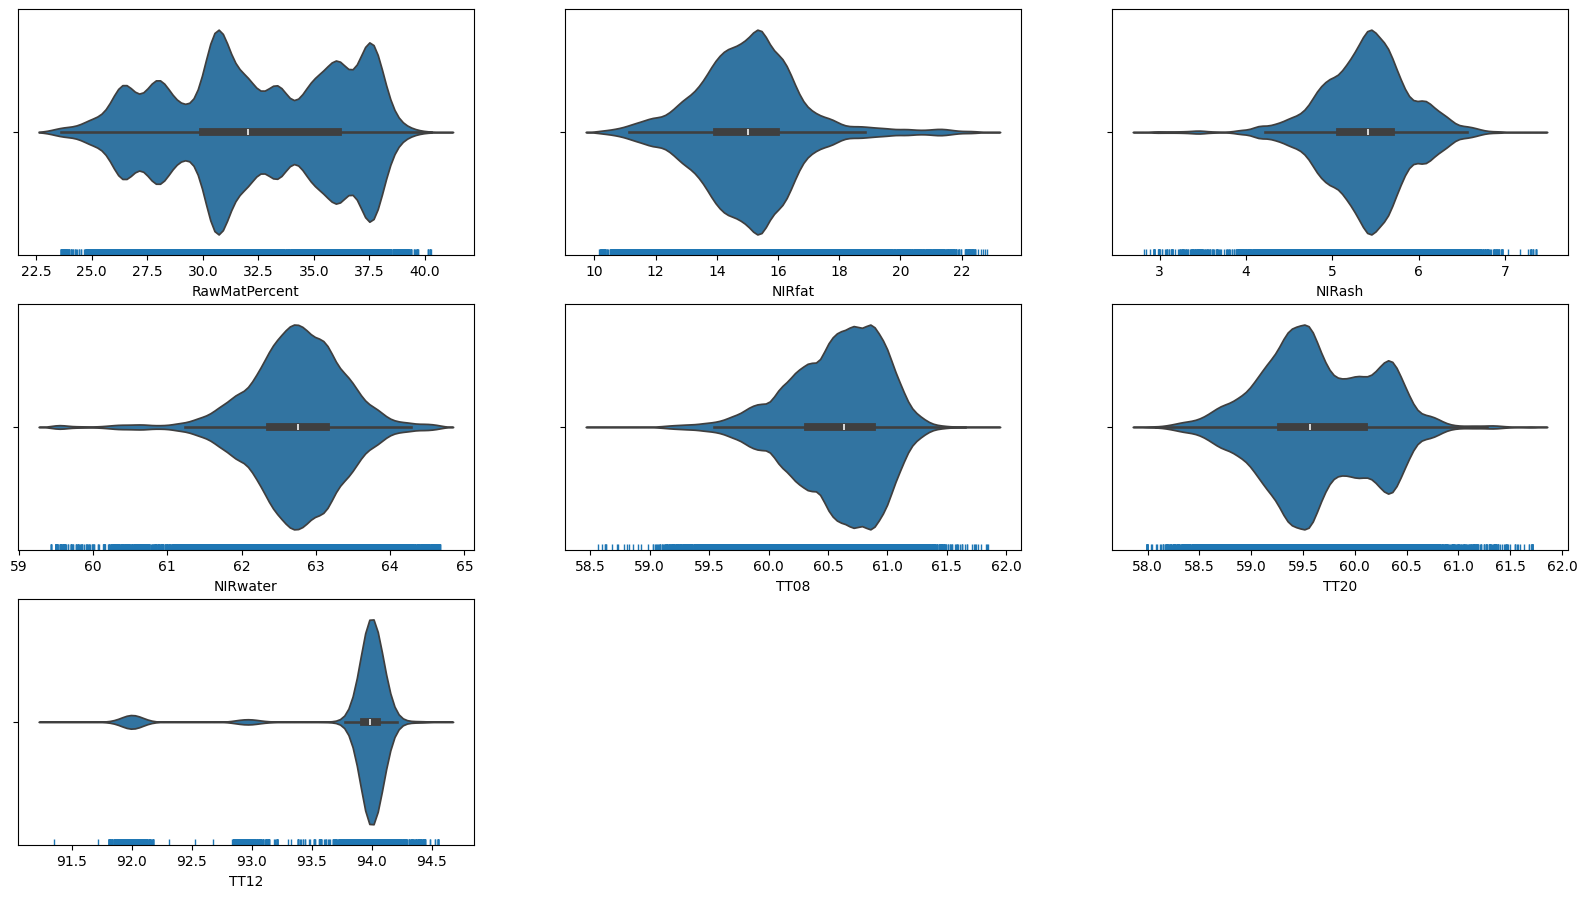

In [59]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_cblof.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_cblof):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_cblof)
  sns.rugplot(x=behandlet_data_cblof[indeks])
  i += 1

Ekstremverdi inspeksjon med DBSCAN

In [133]:
# Parametere for DBSCAN
eps = 0.25
min_observasjoner = 5

# DBSCAN modell
dbscan_model = DBSCAN(eps=eps, min_samples=min_observasjoner)
dbscan_model.fit(X)

# Henter labels, -1 markert som ekstrem observasjon
y_predikert_dbscan = dbscan_model.labels_

mulige_ekstrem_dbscan_indeks = np.where(y_predikert_dbscan == -1)[0]
# Filtrerer bort ekstreme observasjoner
behandlet_data_dbscan = prediktor_data[y_predikert_dbscan != -1]

# Data etter inspeksjon med HBOS
print("Data etter DSCAN:")
print(behandlet_data_dbscan.info())

Data etter DSCAN:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27130 entries, 2022-10-31 17:37:00 to 2023-06-14 00:57:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  27130 non-null  float64
 1   NIRfat         27130 non-null  float64
 2   NIRash         27130 non-null  float64
 3   NIRwater       27130 non-null  float64
 4   TT08           27130 non-null  float64
 5   TT20           27130 non-null  float64
 6   TT12           27130 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB
None


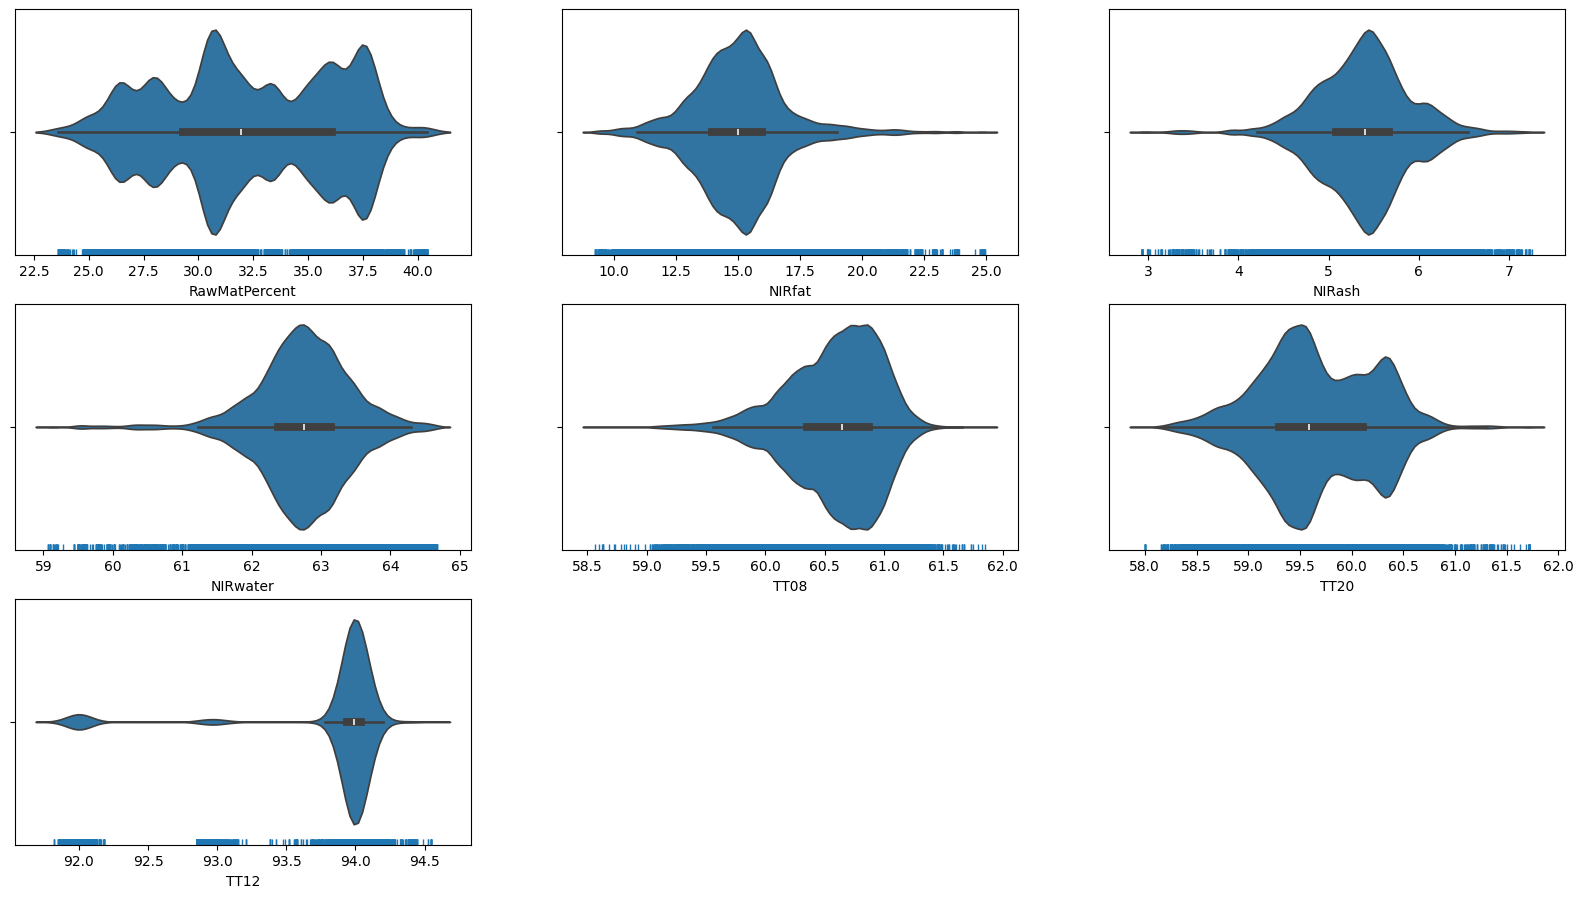

In [63]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_dbscan.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_dbscan):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_dbscan)
  sns.rugplot(x=behandlet_data_dbscan[indeks])
  i += 1

In [148]:
# Finner ektreme observasjoner som er felles for inspeksjonene
samlet_ekstrem_indeks = np.intersect1d(mulige_ekstrem_hbos_indeks, mulige_ekstrem_cblof_indeks)

samlet_ekstrem_indeks = np.intersect1d(samlet_ekstrem_indeks, mulige_ekstrem_dbscan_indeks)


# Remove the common outliers from the original DataFrame
prediktor_data_ekstrem = prediktor_data.drop(prediktor_data.index[samlet_ekstrem_indeks])

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(prediktor_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28890 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  28890 non-null  float64
 1   NIRfat         28890 non-null  float64
 2   NIRash         28890 non-null  float64
 3   NIRwater       28890 non-null  float64
 4   TT08           28890 non-null  float64
 5   TT20           28890 non-null  float64
 6   TT12           28890 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None


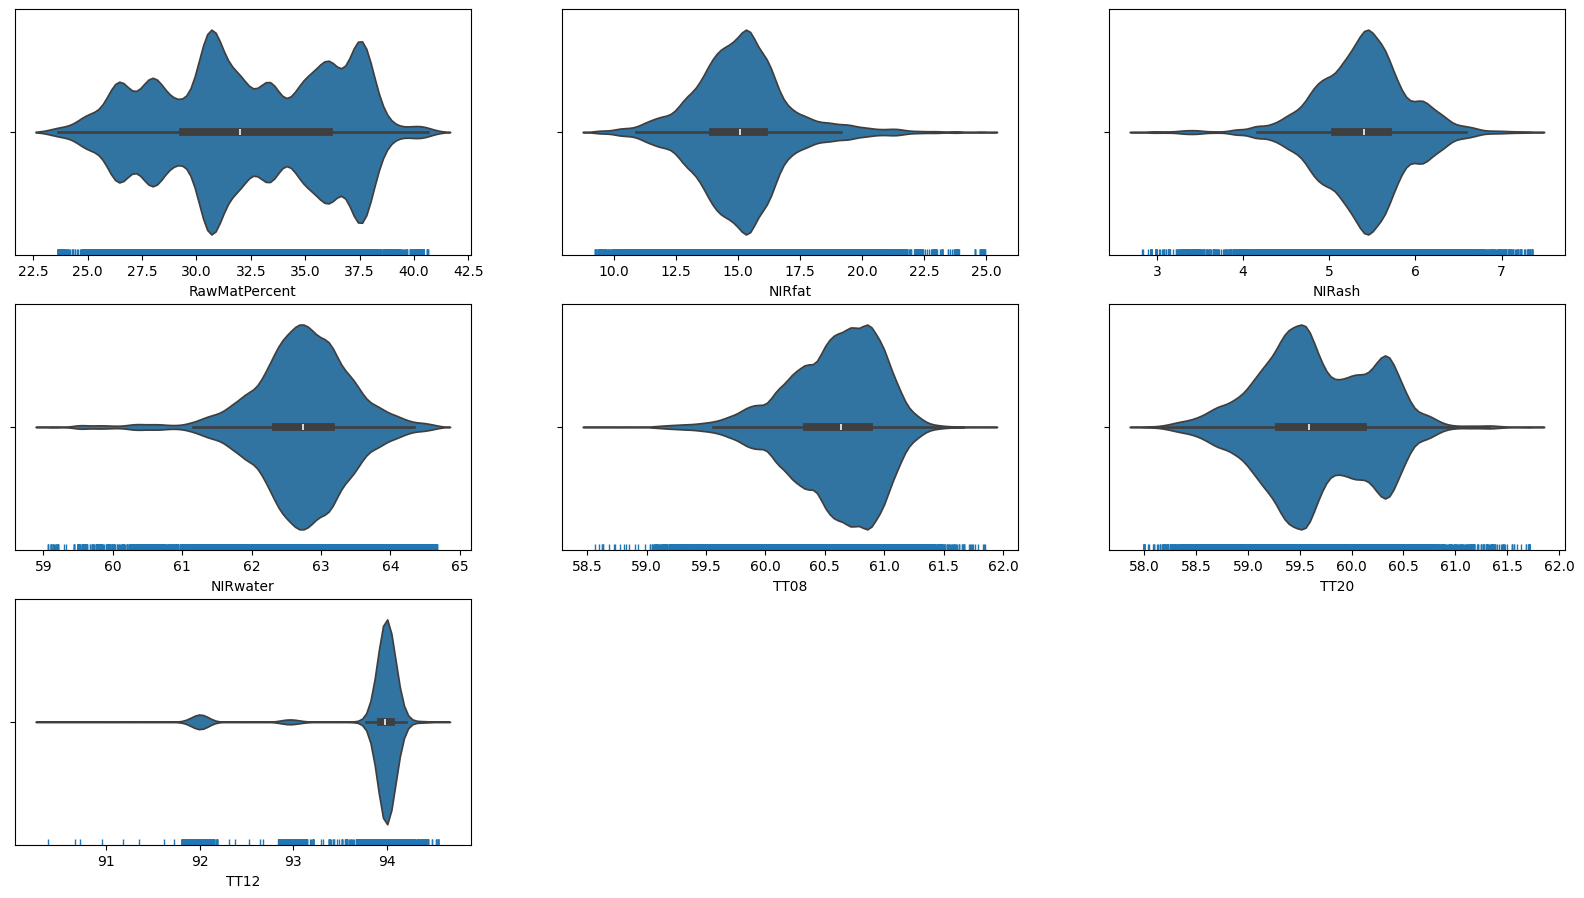

In [149]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data_ekstrem.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data_ekstrem):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data_ekstrem)
  sns.rugplot(x=prediktor_data_ekstrem[indeks])
  i += 1

In [150]:
# Ekskluderer ektreme observasjoner fra behandlet data
behandlet_data_ekstrem = behandlet_data.loc[prediktor_data_ekstrem.index]

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(behandlet_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28890 entries, 2022-10-31 17:37:00 to 2023-06-14 01:02:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   28890 non-null  int64  
 1   EnzymeType_A2   28890 non-null  int64  
 2   EnzymeType_B    28890 non-null  int64  
 3   EnzymeType_C    28890 non-null  int64  
 4   EnzymeType_D    28890 non-null  int64  
 5   EnzymeType_E    28890 non-null  int64  
 6   RawMatPercent   28890 non-null  float64
 7   NIRfat          28890 non-null  float64
 8   NIRash          28890 non-null  float64
 9   NIRwater        28890 non-null  float64
 10  TT08            28890 non-null  float64
 11  TT20            28890 non-null  float64
 12  TT12            28890 non-null  float64
 13  Collagen        86 non-null     float64
 14  Mw              450 non-null    float64
 15  SmallMolecules  450 non-null    float64
 16  BrixAdjuste

Undersøker de ekstreme observasjonene

In [151]:
ekstrem_data =  behandlet_data.drop(behandlet_data_ekstrem.index)

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(ekstrem_data.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 246 entries, 2022-11-02 10:50:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   246 non-null    int64  
 1   EnzymeType_A2   246 non-null    int64  
 2   EnzymeType_B    246 non-null    int64  
 3   EnzymeType_C    246 non-null    int64  
 4   EnzymeType_D    246 non-null    int64  
 5   EnzymeType_E    246 non-null    int64  
 6   RawMatPercent   246 non-null    float64
 7   NIRfat          246 non-null    float64
 8   NIRash          246 non-null    float64
 9   NIRwater        246 non-null    float64
 10  TT08            246 non-null    float64
 11  TT20            246 non-null    float64
 12  TT12            246 non-null    float64
 13  Collagen        3 non-null      float64
 14  Mw              10 non-null     float64
 15  SmallMolecules  10 non-null     float64
 16  BrixAdjusted 

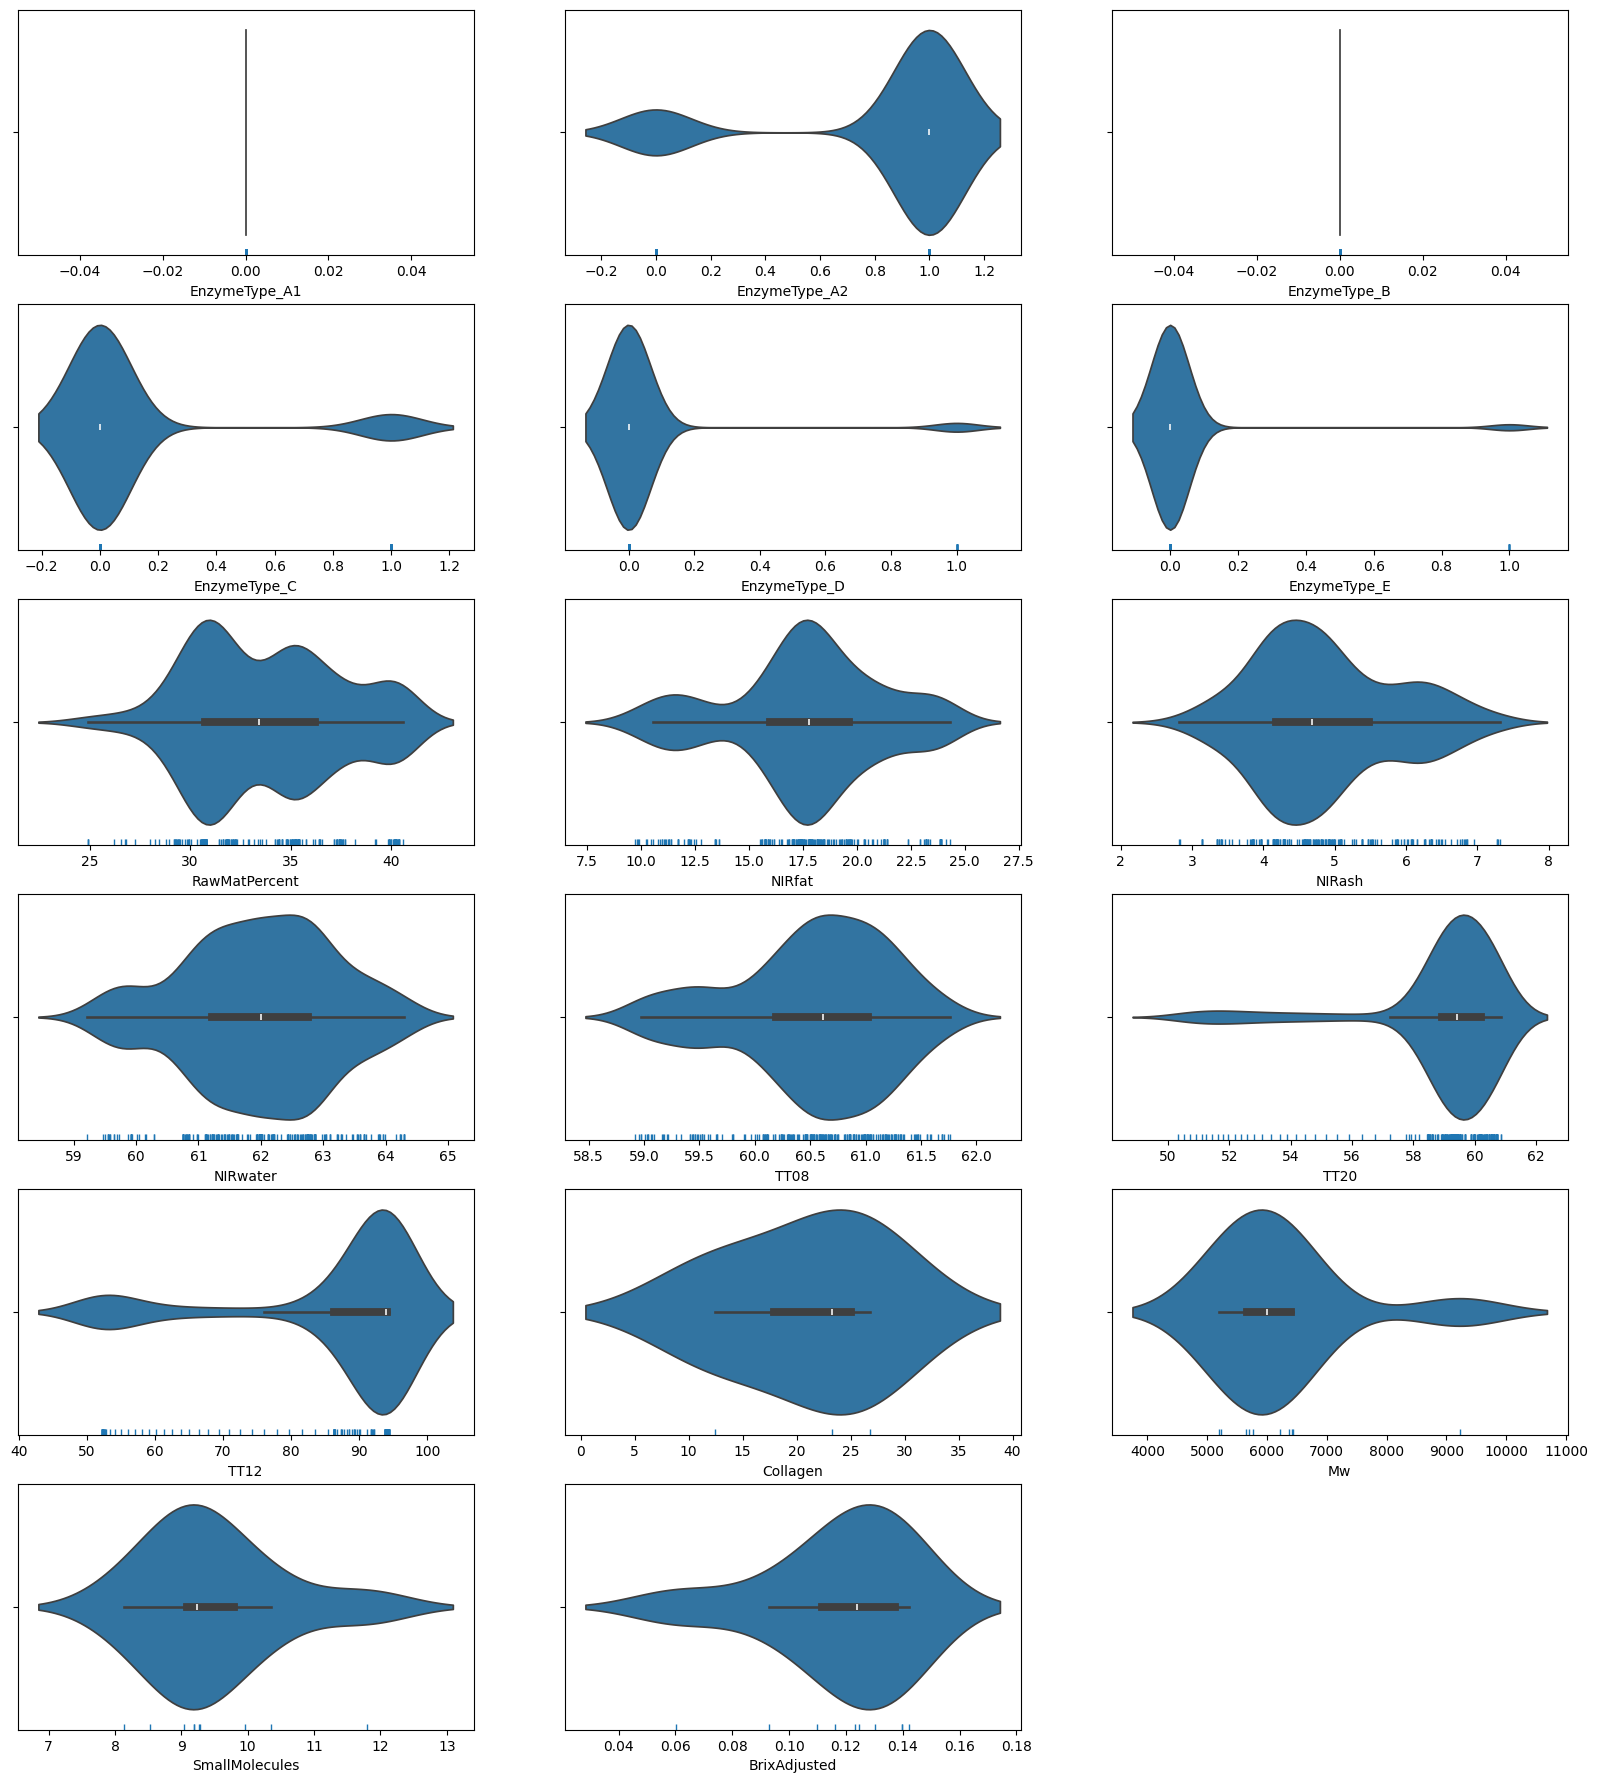

In [152]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(ekstrem_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), ekstrem_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = ekstrem_data)
  sns.rugplot(x=ekstrem_data[indeks])
  i += 1

In [160]:
ekstrem_data_filtrert = ekstrem_data.dropna(subset=['Mw'])

In [161]:
ekstrem_data_filtrert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-11-08 09:10:00,0,0,0,1,0,0,37.309388,9.890575,6.843597,64.237426,59.47852,59.446620,93.927085,12.45,6367.759861,11.793522,0.109892
2022-11-09 03:40:00,0,0,0,1,0,0,36.576786,23.304880,3.517601,59.925843,60.66124,59.984395,94.066335,NaN,9228.047913,8.142964,0.092955
2022-12-01 12:50:00,0,1,0,0,0,0,34.801911,17.842532,5.381879,62.006226,60.52561,59.332900,86.508825,23.29,5235.432713,9.264557,0.060342
2022-12-13 09:40:00,0,1,0,0,0,0,32.054761,19.475465,4.579760,62.043946,61.26345,59.321055,94.398000,NaN,6414.969666,9.197097,0.124786
2022-12-13 09:45:00,0,1,0,0,0,0,31.639288,20.073750,4.505190,61.406672,61.58897,59.520060,94.149885,NaN,6433.265780,8.521806,0.123264
2022-12-13 10:00:00,0,1,0,0,0,0,32.207659,21.250747,3.851002,60.754326,60.81315,59.306835,93.876450,26.81,5761.500503,9.044750,0.130404
2022-12-13 10:05:00,0,1,0,0,0,0,32.898636,21.250747,3.851002,60.794752,60.46050,59.136265,93.876450,NaN,5652.275321,9.190380,0.139823
2022-12-13 10:10:00,0,1,0,0,0,0,33.751545,20.329135,4.048187,61.492496,60.23264,58.975170,93.924555,NaN,5704.743362,9.287835,0.142216
2022-12-13 11:20:00,0,1,0,0,0,0,35.090315,18.385171,4.729098,62.442586,59.44054,58.617445,94.116965,NaN,5206.376333,9.966461,0.139640


Lagring av data behandlet for ekstreme verdier som csv

In [ ]:
behandlet_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/ekstremverdi_data_behandlet_bioco_data.csv')